In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [6]:
class MseriesGeneratorClass:
    def __init__(self, k, Tc, binary=[0,1]):
        self._generate_vec = np.vectorize(self._generate)
        
        comb = np.array([
            [2, 1], [3, 1], [4, 1], [5, 2], [6, 2], [7, 1],
            [7, 3], [10,3], [17,3], [18,7], [21,2], [22,1]])
        
        (self._p, self._q) = comb[k]
        self._Tc = Tc
        self._T = 2**self._p - 1
        self._binary = binary
        self._mseries = [1] + [0 for i in range(self._p-1)]
        for i in range(self._p, self._T):
            self._mseries.append(self._mseries[i-self._p] ^ self._mseries[i-self._q])
        self._mseries = np.array(self._mseries)
        print(f"p = {self._p}, q = {self._q}, T = {self._T}")
    
    def get_period(self):
        return self._T
    
    def get_mseries(self):
        return self._mseries
    
    def _generate(self, t):
        k = int(t/self._Tc)
        if k > self._T-1:
            k = k % self._T
        else:
            pass #nothing
        u = self._mseries[k]
        if u > 0:
            u = self._binary[1]
        else:
            u = self._binary[0]
        return u
    
    def output(self, t):
        if type(t) == float:
            u = self._generate(t)
        else:
            u = self._generate_vec(t)
        return u


class PlantClass:
    def __init__(self):
        # ++ Parameter ++
        I1 = 9.38062e-4 # [kgm^2] ....... 慣性モーメント（振子部）
        I2 = 6.56e-4       # [kgm^2] ....... 慣性モーメント（ロータ部）
        m1 = 0.669        # [kg] .......... 振子部の質量（モータを含む）
        m2 = 0.519        # [kg] .......... ロータ部の質量
        lg = 0.059758    # [m] ........... 主軸 - 重心間の距離
        l  = 0.157           # [m] ........... 軸間距離（主軸 - ロータ軸）
        c1 = 0.02           # [Nm.sec/rad] .. 粘性摩擦トルク係数（第1軸）
        c2 = 0.009         # [Nm.sec/rad] .. 粘性摩擦トルク係数（第2軸）
        Kt = 2.07e-3       # [Nm/A] ........ トルク定数
        Ka = 1                # [--] .......... DCアンプゲイン
        Rm = 2.8            # [Ω] ........... 抵抗
        gr = 1/51           # [--] .......... 減速比
        g  = 9.81            # [m/s^2] ....... 重力加速度

        I = I1 + m1 * lg**2 + m2 * l**2
        b = (Kt * Ka) / (gr * Rm)
        f = (m1 * lg + m2 * l) * g / I
        b1 = b/I
        b2 = b/I + b/I2

        # ++ State Space Matrix ++
        self._A = np.array([
            [0, 0, 1, 0],
            [0, 0, 0, 1],
            [0, 0,-c1/I, c2/I],
            [0, 0, c1/I, -(c2/I + c2/I2)]
        ])
        self._B = np.array([0, 0, -b1, b2])
        self._F = np.array([0, 0, -f, f])
        
        # Linearized system matrix "A"
        #self._Al = np.array([
        #    [   0, 0, 1, 0],
        #    [   0, 0, 0, 1],
        #    [-f/I, 0,-c1/I, c2/I],
        #    [ f/I, 0, c1/I, -(c2/I + c2/I2)]])
        
    def act(self, x, u):
        return self._A.dot(x) + self._B*u + self._F*np.sin(x[0])

    
class RecorderClass:
    def __init__(self):
        self._t = []
        self._x = []
        
    def reset(self):
        self._t = []
        self._x = []
    
    def rec(self, t, x):
        self._t.append(t)
        self._x.append(x)
    
    def get_rec(self):
        return (np.array(self._t), np.array(self._x))
    
    

In [8]:
#Tc  = 0.015    # when M-Series type1
#Tc  = 0.006    # when M-Series type2
Tc  = 0.0165  # when M-Series type3

In [9]:
high_value = 0.0
low_value = 12.0

plant = PlantClass()
gen = MseriesGeneratorClass(7, Tc, binary=[low_value, high_value])

print(f"M-Series signal's period: {Tc*gen.get_period():.3f}[sec]")

# define control-system
def system(x, t):
    u = gen.output(t)
    return plant.act(x, u)

p = 10, q = 3, T = 1023
M-Series signal's period: 16.880[sec]


In [10]:
Ts  = 0.001
sim_time = 20.0+Ts
t_span = np.arange(0, sim_time, Ts)

In [12]:
x0 = [0., 0., 0., 0.]
resp_x = odeint(system, x0, t_span)
ref_u = gen.output(t_span)

In [13]:
dxdt = []
for i in range(ref_u.size):
    dxdt.append(plant.act(resp_x[i],ref_u[i]))
dxdt = np.array(dxdt)

data = np.hstack((resp_x, dxdt[:,2:], ref_u[:,np.newaxis]))

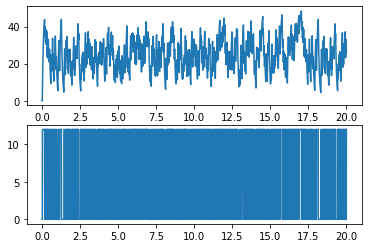

In [14]:
# check the results
plt.subplot(211)
plt.plot(t_span, resp_x[:,3])

plt.subplot(212)
plt.plot(t_span, ref_u)

In [15]:
df_respx = pd.DataFrame({
    "Time[sec]": np.round(t_span[:-1],3),
    "x1[k]": data[:-1, 0],
    "x2[k]": data[:-1, 1],
    "x3[k]": data[:-1, 2],
    "x4[k]": data[:-1, 3],
    "d/dt x3[k]": data[:-1, 4],
    "d/dt x4[k]": data[:-1, 5],
    "voltage": data[:-1, 6]
})

df_respy = pd.DataFrame({
    "Time[sec]": np.round(t_span[1:],3),
    "x1[k+1]": data[1:, 0],
    "x2[k+1]": data[1:, 1],
    "x3[k+1]": data[1:, 2],
    "x4[k+1]": data[1:, 3]
})

In [ ]:
data_label = "ms3b"

df_respx.to_csv(f"{data_label}_x.csv", index=False)
df_respy.to_csv(f"{data_label}_y.csv", index=False)